# Analysis of Audience participant body sway, MusicLab Copenhagen


Generation of plots for Audience Motion paper

In [6]:
import sys
import os
import time

import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib.cm as cm
import pingouin as pg

import matplotlib.gridspec as gridspec

In [7]:
# import functions from definition files in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport am
%aimport frf

In [8]:
%reload_ext autoreload

# Data preparation 
Aligning cellphone accelerometer measurements collected via MusicLab App and AX3 measurements from audience participant was performed in a different repository. This process depended on the detection of taps by participants on their devices to the synchronisation cues played before each half of the concert. See Notebook below for a summary of that work to align accelerometer measurements: 
https://github.com/finn42/MusicLabCopenhegan_MotionAlignment/blob/main/Alignment_Describe.ipynb

These aligned accelerometer measurments were released publically as part of the MusicLab Copenhagen repository (https://osf.io/v9wa4/). This analysis uses the fullowing published datasets from this study:

  1. Aligned accelerometer measurements from each audience member: https://osf.io/9qeg6/
  2. Participants' survey responses: https://osf.io/89s5w/ 
  3. Anonimised seating information for in hall participants: https://osf.io/8t4rz/ ./Participants/Near_Participants_Hall.csv (https://osf.io/c5zgf)
  4. Concert event timing information:  https://osf.io/8t4rz/ ./Timing/Events_Main.csv

In [9]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [10]:
internal_Part = general_loc + 'Participants_internal/'

In [11]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)


In [12]:
# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


In [18]:
concert_times = pd.read_csv(public_time +'Events_Main_Segments.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [19]:
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping', ]
Main_concert_times['Sections']=''
for ev in evord:
    Main_concert_times.loc[Main_concert_times['Event'].str.startswith(ev[:4]),'Sections'] = ev

Main_concert_times.iloc[:5,:]

,Time_s,Time_ms,Event,Event_Type,Time_Stream,Event_Duration,Shorter_tag,sequence,Sections
Datetime,,,,,,,,,
2021-10-26 17:36:35,-691.24,-691240,Clapping for MC,Applause,946.00,18.12,Claps 0,0,Clapping
2021-10-26 17:36:53,-673.12,-673120,Speech,Speech,964.12,117.08,Speech 1,1,Speech
2021-10-26 17:38:50,-556.04,-556040,Clapping for MC,Applause,1081.20,5.88,Claps 1,2,Clapping
2021-10-26 17:38:59,-547.16,-547160,Speech MC1,Speech,1090.08,377.52,Speech 2,3,Speech
2021-10-26 17:45:16,-169.64,-169640,Clapping for MC,Applause,1467.60,1.05,Claps 1.1,4,Clapping


In [20]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
part_det_columns = ['Participant_Code','Attendance', 'Motion_Quality', 'Seat_Zone','Watch_Alone']
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'].isin(['A','B']),part_det_columns] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts.iloc[:5,:]

,Participant_Code,Attendance,Motion_Quality,Seat_Zone,Watch_Alone
0,ADQ001,A,Q,6.0,0.0
1,ADQ002,A,Q,3.0,0.0
2,ADQ003,A,Q,2.0,0.0
3,ADQ004,A,Q,4.0,1.0
4,ADQ005,A,Q,4.0,0.0


One of the unfortunate characteristics of the cellphone measurements is their inconsistent sample rates and frequent gaps. Measurements per device were transmitted in 60 s batches, however there were (for as of yet undetermined reasons) often gaps between batches, sometimes of several seconds. These frequent discontinuities complicate how this data can be treated. Some steps taken were necessary compromises because of these measurement issues. There were also discontinuities from participants turning off the app to answer questions (remote participants only) or during intermission. To handle these gaps with care throughout these analyses, we inserted NaN values in any gaps lasting more than a second before resampling the ACC measurements to get Quantity of Motion measures on common timestamp values.

Lastly there was some data loss from phones lossing power or th app being accidentally or incidentally turned off/closed.

The individual participants accelerometer measurements during the concert experiment were resampled to matching timestamps at 50 Hz

In [21]:
tic = time.time()

# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000
trial_dic = {}
for i, participant in alignedParts.iterrows(): # .loc[21:21,:]
    part = participant['Participant_Code']
    print(part)
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = am.gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
#         aud_df.loc[:,part] = b*6 # could go down to 5, based on distributions (high end)
        trial_dic[part] = pd.Series(index=dt_ct,data=b*5)
    else:
        trial_dic[part] = pd.Series(index=dt_ct,data=b)
print(time.time()-tic)   
aud_df = pd.concat(trial_dic,axis=1)
print(time.time()-tic)
aud_df.index = dt_ct

ADQ001
ADQ002
ADQ003
ADQ004
ADQ005
ADQ006
ADQ007
ADQ008
ADQ009
ADQ010
ADQ011
ADQ012
ADQ013
ADQ014
ADQ015
ADQ016
ADQ017
ADQ018
ADQ019
ADQ020
ADQ021
ADQ022
ADQ023


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x

ADQ024
ADQ025
ADQ026
ADQ027
ADQ028
ADQ029
ADQ030
ADQ031
ADQ032
ADQ033
ADQ034
ADQ035
ADQ036
ADQ037
ADQ038
ADQ039
ADQ040
ADQ041
ADQ042
ADQ043
ADQ044
ADQ045
ADQ046
ADQ047
ADQ048
ADQ049
ADQ050
ADQ051
ADQ052
ADQ053
ADQ054
ADQ055
ADQ056
ADQ057
ADQ058
ADQ059
ADQ060
ADQ061
ADQ062
ADQ063
ADQ064
ADQ065
ADQ066
ADR067
ADR068
ADR069
ADR070
ADR071
AEQ077
AEQ078
AEQ079
AEQ080
AEQ081
AEQ082
AEQ083
AEQ084
AEQ085
AEQ086
AEQ087
AEQ088
AEQ089
AER090
BDQ092
BDQ093
BEQ095
BEQ096
BEQ097
BEQ098
BEQ099
BEQ100
BEQ101
BEQ102
BEQ103
BEQ104
BEQ105
BEQ106
BEQ107
BEQ108
BEQ109
BEQ110
BEQ111
BEQ112
BEQ113
BEQ114
BEQ115
BEQ116
BEQ117
BEQ118
BEQ119
BnQ131
BnQ132
BnQ133
103.58879804611206
103.65662217140198


In [22]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
part_det_columns = ['Participant_Code','Attendance', 'Motion_Quality', 'Seat_Zone','Watch_Alone']
partDets = partDets.loc[partDets['Attendance'].isin(['A','B']),part_det_columns] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts.iloc[:5,:]

,Participant_Code,Attendance,Motion_Quality,Seat_Zone,Watch_Alone
0,ADQ001,A,Q,6.0,0.0
1,ADQ002,A,Q,3.0,0.0
2,ADQ003,A,Q,2.0,0.0
3,ADQ004,A,Q,4.0,1.0
4,ADQ005,A,Q,4.0,0.0


In [23]:
aud_df.index = (ts_ct/1000).round(1)
ori_aud_df = aud_df.copy()
# ori_aud_df.index = (ts_ct/1000).round(1) # convert to seconds from milliseconds


In [25]:
#aligned_Part_Codes[:85], aligned_Part_Codes[85:]
AUD = aud_df.loc[:,aligned_Part_Codes[:85]].copy()
AUD['Virtual'] = np.nan
AUD['Virtual.'] = np.nan
AUD['Virtual..'] = np.nan
AUD['Virtual...'] = np.nan
AUD['Virtual....'] = np.nan
AUD = pd.concat([AUD,aud_df.loc[:,aligned_Part_Codes[85:]].copy()],axis=1)

[-691.24, 8352.060000000001]


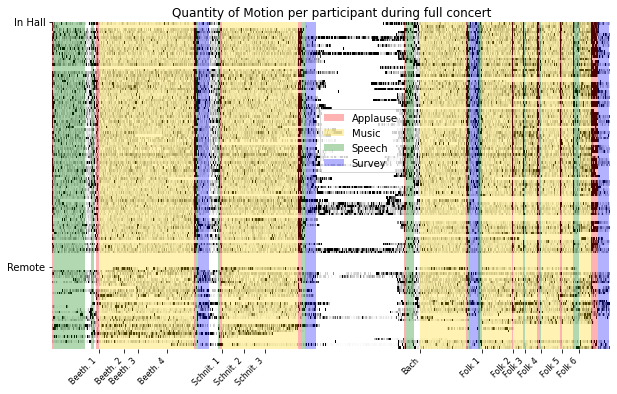

In [27]:
seg_start = concert_times.iloc[0,:].Time_s #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[53,:].Time_s + 200
print([seg_start,seg_end])
Event_Pallet={'Applause':'red','Music':'gold','Speech':'green','Survey':'blue','Synch':'purple'}
alpha_factor = 0.3

# seg_times = Main_concert_times.copy()
seg_df = AUD.loc[seg_start:seg_end].copy()
seg_df = seg_df.fillna(0)

fig, (ax1) = plt.subplots(1, 1,figsize = [10,6])
chart = sns.heatmap(data=-seg_df.transpose(), ax=ax1,vmin=-0.5, vmax=0,cbar=False, cmap=cm.gray)

seg_times = concert_times.loc[concert_times['Event_Type'].isin(['Music'])]
new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end -seg_start)
plt.xticks(new_xticks,seg_times.Shorter_tag, fontsize=8, ha='right')
ax1.tick_params(axis='x', labelrotation=45)
seg_times = concert_times#.loc[concert_times['Event_Type'].isin(['Speech','Music'])]
new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end -seg_start)
new_dur = len(seg_df)*(seg_times['Event_Duration'])/(seg_end -seg_start)
new_dur_survey = len(seg_df)*(180)/(seg_end -seg_start)
xrange = [0,180]

ax1.margins(0)
ax1.axvspan(seg_start,xrange[0],0,1, facecolor='red',label="Applause",alpha=alpha_factor)
ax1.axvspan(seg_start,xrange[0],0,1,  facecolor='gold',label="Music",alpha=alpha_factor)
ax1.axvspan(seg_start,xrange[0],0,1, facecolor='green',label="Speech",alpha=alpha_factor)
ax1.axvspan(seg_start,xrange[0],0,1, facecolor='blue',label="Survey",alpha=alpha_factor)

ax1.legend(loc='upper left', bbox_to_anchor=(0.47,0.75))


alpha_factor = 0.3
yrange = [0,120.0]
for i in range(len(seg_times)-1):
    r= seg_times.iloc[i,:]
    ei = new_xticks[i]
    ej = new_xticks[i] + new_dur[i]
    if r['Event_Type'].startswith('Applause'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='red', alpha=alpha_factor)
    if r['Event_Type'].startswith('Musi'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='gold', alpha=alpha_factor)
    if r['Event_Type'].endswith('Speech'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='green', alpha=alpha_factor)
    if r['Event_Type'].startswith('Survey'):
        ej = new_xticks[i] + new_dur_survey
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='blue', alpha=alpha_factor)

ax1.set_yticks([0,90])
ax1.set_yticklabels(['In Hall','Remote'])
# ax1.set_xticklabels(cmoments['Event'])
plt.title('Quantity of Motion per participant during full concert')
plt.savefig('./plots/qom_n_full_colour.png', bbox_inches = 'tight',dpi = 196)
plt.show()


# Scaling, segmentation and preliminary analysis
using 50 Hz sampled measurements.

In [28]:
aud_df.index = dt_ct        
ori_aud_df = aud_df.copy()
ori_aud_df.index = (ts_ct/1000).round(1)


In [29]:
ori_aud_df.iloc[:5,:]

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,BEQ113,BEQ114,BEQ115,BEQ116,BEQ117,BEQ118,BEQ119,BnQ131,BnQ132,BnQ133
-1086.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1085.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1085.8,0.740777,0.467856,0.212834,0.101379,0.234912,0.224302,0.486310,0.064859,0.247404,0.237059,...,0.032345,NaN,NaN,NaN,NaN,0.227207,NaN,NaN,NaN,NaN
-1085.7,0.691307,0.179505,0.349901,0.100000,0.249657,0.184666,0.597926,0.055355,0.543207,0.371191,...,0.010653,NaN,NaN,NaN,NaN,0.183257,NaN,NaN,NaN,NaN
-1085.6,0.711500,0.137325,0.154668,0.063158,0.181522,0.134561,0.456580,0.072090,0.082915,1.156659,...,0.017225,NaN,NaN,NaN,NaN,0.140195,NaN,NaN,NaN,NaN


In [131]:
minDur=60

In [132]:
ev_tags = ['Beethoven','Schnittke','Bach','Folk','Survey','Speech','Clapping']
df = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)
for ev_tag in ev_tags:
    MTs = Main_concert_times.query('Sections==@ev_tag and Event_Duration > @minDur')
    sigs = []
    for i,r in MTs.iterrows():
         sigs.append(ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy())
    fullset = pd.concat(sigs,axis=0)
    df.loc[ev_tag,:] = fullset.mean()
df

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,BEQ113,BEQ114,BEQ115,BEQ116,BEQ117,BEQ118,BEQ119,BnQ131,BnQ132,BnQ133
Beethoven,0.069311,NaN,0.094418,0.101837,0.07339,0.108468,0.079436,0.086562,0.078947,0.132908,...,0.050851,0.209203,0.106644,0.164509,0.342741,0.182293,NaN,0.084129,0.272131,NaN
Schnittke,NaN,NaN,0.09243,0.143013,0.08211,0.1171,0.071236,0.08482,0.083305,0.106298,...,NaN,0.324734,0.160088,0.174884,0.288465,0.168656,NaN,NaN,0.142764,NaN
Bach,0.056344,0.135229,0.095909,0.124146,0.076237,0.103214,0.072805,0.075133,0.063821,0.103792,...,NaN,NaN,0.161927,NaN,NaN,NaN,0.041645,0.080859,0.044488,0.064046
Folk,0.090395,0.110848,0.12164,0.16044,0.102084,0.103741,0.122425,0.108638,0.077485,0.166454,...,0.13115,NaN,0.31208,1.033047,NaN,NaN,NaN,0.099888,0.068717,0.11593
Survey,0.209239,0.276741,0.138638,0.390651,0.154346,0.20982,0.193861,0.116464,0.160078,0.598902,...,2.63744,0.300593,NaN,0.21808,0.455517,NaN,NaN,0.257953,0.263718,0.225292
Speech,0.163682,0.260689,0.296558,0.231577,0.125858,0.166728,0.116513,0.112045,0.115769,0.330659,...,NaN,0.482708,0.127551,0.716373,NaN,0.259556,0.02373,0.105133,0.465619,0.162762
Clapping,0.903431,1.050359,1.149658,1.383438,0.679812,1.88919,1.528213,1.328942,1.003264,1.406358,...,0.428255,0.739514,0.957739,0.021591,NaN,NaN,NaN,0.331674,0.277735,0.421537


In [133]:
mu = df.loc['Speech',df.columns.str.startswith('A')].median()
#scalling factor, just for simplicity of plotting. 
mu

0.15316226730411814

In [134]:
ev_tags = ['Beethoven','Schnittke','Bach','Folk','Survey','Speech','Clapping']
df = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)
for ev_tag in ev_tags:
    MTs = Main_concert_times.query('Sections==@ev_tag and Event_Duration > @minDur')
    sigs = []
    for i,r in MTs.iterrows():
         sigs.append(ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy())
    fullset = pd.concat(sigs,axis=0)
    df.loc[ev_tag,:] = fullset.mean()
results = df.loc[:,df.columns.str.startswith('A')].copy()/mu
res1 = pd.melt(results.transpose(),var_name = 'Event',value_name ='Quantity of Movement (QoM)')
res1['Sections'] = 'Music'
ev_tags = ['Survey','Speech','Clapping']
for ev_tag in ev_tags: res1.loc[res1['Event'].str.startswith(ev_tag[:4]),'Sections']=ev_tag

In [135]:
ev_tags = ['Music']
df = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)
for ev_tag in ev_tags:
    MTs = Main_concert_times.query('Event_Type==@ev_tag and Event_Duration > @minDur')
    for i,r in MTs.iterrows():
        if r['Event_Duration']> min_dur:
            sigs = ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:]
            df.loc[r['Shorter_tag'],:] = sigs.mean()

# inhall only,scaled for plotting
results = df.loc[:,df.columns.str.startswith('A')].copy()/mu
res2 = pd.melt(results.transpose(),var_name = 'Event',value_name ='Quantity of Movement (QoM)')
res2['Sections'] = 'Music'

In [136]:
ev_tags = ['Survey','Speech','Applause']
Segs = []
for ev_tag in ev_tags: Segs.append(Main_concert_times.query('Event_Type==@ev_tag and Event_Duration > @minDur'))
MTs = pd.concat(Segs,axis=0)

ev_tags = MTs['Shorter_tag']
df = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)
for i,r in MTs.iterrows():
    sigs=ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy()
    df.loc[r['Shorter_tag'],:] = sigs.mean()

# inhall only,scaled for plotting
results = df.loc[:,df.columns.str.startswith('A')].copy()/mu
print(results.index)
res3 = pd.melt(results.transpose(),var_name = 'Event',value_name ='Quantity of Movement (QoM)')
res3['Sections'] = ''
ev_tags = ['Survey','Speech','Clapping']
for ev_tag in ev_tags: res3.loc[res3['Event'].str.startswith(ev_tag[:4]),'Sections']=ev_tag

Index(['Survey 1', 'Survey 2', 'Survey 3', 'Survey 4', 'Speech 1', 'Speech 2',
       'Speech 7', 'Claps 5', 'Claps 14'],
      dtype='object', name='Shorter_tag')


In [140]:
musord = ['Survey 1', 'Survey 2', 'Survey 3', 'Survey 4','Speech 1', 'Speech 2',
        'Speech 7','Claps 5', 'Claps 14']

In [141]:
sns.reset_defaults()

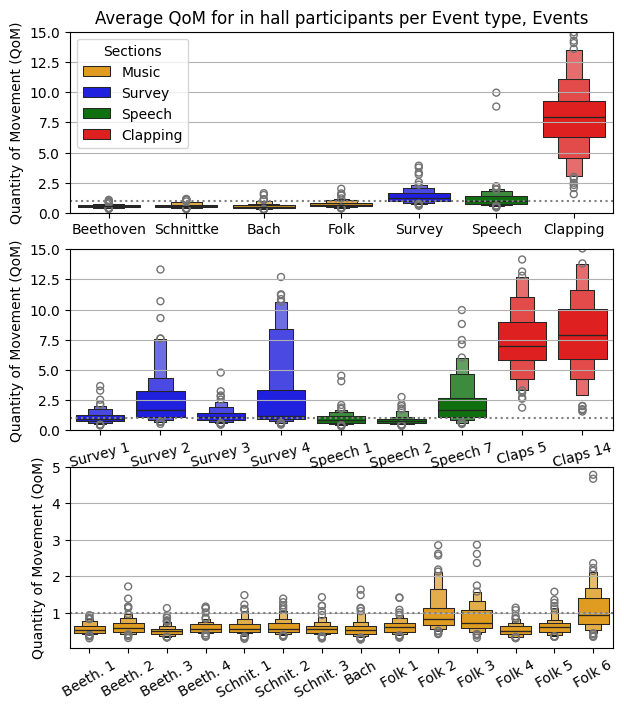

In [143]:
# sns.set_style('whitegrid')
plt.figure(figsize=(7, 8)) #, dpi=90
 
event_palette = {'Music':'orange','Survey':'blue', 'Speech':'green','Clapping':'red'}
plt.subplot(3, 1, 1)
ax = sns.boxenplot(data=res1, x='Event', y='Quantity of Movement (QoM)', hue =  'Sections',showfliers = True, palette=event_palette)
ax.set(xlabel=None)
plt.xticks(rotation=0)
plt.axhline(y=1, color='gray', linestyle=':')
ax.grid(axis='y')
ax.set_ylim([0,15])
ax.set_title('Average QoM for in hall participants per Event type, Events')

plt.subplot(3, 1, 2)
ax=sns.boxenplot(data=res3, x='Event', y='Quantity of Movement (QoM)', order = musord, hue =  'Sections', showfliers = True,legend = False,  palette=event_palette)
ax.set(xlabel=None)
plt.xticks(rotation=15)
plt.axhline(y=1, color='gray', linestyle=':')
ax.set_ylim([0,15])
ax.grid(axis='y')
#
plt.subplot(3, 1, 3)
ax=sns.boxenplot(data=res2, x='Event', y='Quantity of Movement (QoM)', hue = 'Sections', showfliers = True, legend = False, palette=event_palette)
ax.set(xlabel=None)
plt.xticks(rotation=30)
plt.axhline(y=1, color='gray', linestyle=':')
ax.grid(axis='y')
ax.set_xlim([0.5,14.5])
# plt.tight_layout()
# plt.savefig('plots/Figure_mix_qom',dpi = 196)
plt.savefig('./plots/Figure_QoM_Means.png', bbox_inches = 'tight',dpi = 196)

#
plt.show()